In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep

In [2]:
from PIL import Image
from io import BytesIO
from adjustText import adjust_text

In [3]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name

In [4]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats  # traditional
from nba_api.stats.endpoints.leaguedashptdefend import LeagueDashPtDefend  # defense dash
from nba_api.stats.endpoints.playerdashptshots import PlayerDashPtShots  # shot type, 3pt v 2pt
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs # game logs
from nba_api.stats.endpoints.boxscorematchups import BoxScoreMatchups # mathcups in single game
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail  # shot chart
from nba_api.stats.endpoints.teamplayeronoffsummary import TeamPlayerOnOffSummary  # team player on off
from nba_api.stats.endpoints.leaguedashplayerbiostats import LeagueDashPlayerBioStats  # heights
from nba_api.stats.endpoints.draftcombineplayeranthro import DraftCombinePlayerAnthro  # wingspans/heights

In [5]:
def hustle_url(date_from="", date_to="", season='2019-20'):
    return f"https://stats.nba.com/stats/leaguehustlestatsplayer?College=&Conference=&Country=&DateFrom={date_from}&DateTo={date_to}&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={season}&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&Weight="

In [6]:
def matchup_url(player_id="203496", date_from="", date_to=""):
    """
    Default player_id is Covington's ID
    """
    return f"https://stats.nba.com/stats/matchupsrollup?DateFrom={date_from}&DateTo={date_to}&DefPlayerID={player_id}&LeagueID=00&Matchup=Defense&Outcome=&PORound=0&PerMode=Totals&Season=2019-20&SeasonType=Regular+Season"

In [7]:
def matchup_breakdown(player_id):
    url = f"https://stats.nba.com/stats/matchupsrollup?DateFrom={date_from}&DateTo=&DefPlayerID=&LeagueID=00&Matchup=Defense&Outcome=&PORound=0&PerMode=Totals&Season=2019-20&SeasonType=Regular+Season"
    data = requests.get(url=url, headers=headers).json()
    return pd.DataFrame(data=data['resultSets'][0]['rowSet'], columns=data['resultSets'][0]['headers'])

In [8]:
headers= {
    'Host': 'stats.nba.com', 
    'Connection': 'keep-alive', 
    'Accept': 'application/json, text/plain, */*', 
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36', 
    'Referer': 'https://stats.nba.com/', 
    'Accept-Encoding': 'gzip, deflate, br', 
    'Accept-Language': 'en-US,en;q=0.9',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true',
}

In [9]:
defense_categories = [
    "2 Pointers",
    "3 Pointers",
    "Overall"
]

In [10]:
date_from = "02/06/2020"
date_to = "02/05/2020"

In [11]:
plt.style.use('fivethirtyeight')

## Color definitions

In [12]:
bball_gray = '#312f30'
bball_white = '#dddee0'
bball_orange = '#f87c24'
bball_light_orange = '#fbaf7b'
hou_colors = "#CE1141"
min_colors = "#78BE20"

## Covington data

In [13]:
covington_id = find_players_by_full_name("Robert Covington")[0]['id']

In [14]:
minny_id = find_teams_by_full_name("Minnesota Timberwolves")[0]['id']
hou_id = find_teams_by_full_name("Houston Rockets")[0]['id']

## Introduction

Wingspan, text about D-league, and philly

In [13]:
league_bio = LeagueDashPlayerBioStats().get_data_frames()[0]

In [14]:
combine_data = DraftCombinePlayerAnthro()

In [15]:
data_frames = []

for season in tqdm.tqdm(range(2006, 2020)):
    combine_data = DraftCombinePlayerAnthro(season_year=season)
    data_frames.append(combine_data.get_data_frames()[0])
    sleep(0.5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.15it/s]


In [16]:
concated = pd.concat(data_frames, ignore_index=True)

In [18]:
concated.loc[:, 'HEIGHT_M'] = concated.HEIGHT_WO_SHOES * 2.54
concated.loc[:, 'WINGSPAN_M'] = concated.WINGSPAN * 2.54

In [28]:
merged = pd.merge(left=concated, right=league_bio, on='PLAYER_ID')

In [34]:
merged = merged.loc[merged.GP > 30]

In [35]:
cov_data = concated.loc[concated.PLAYER_ID == covington_id]
other = concated.loc[concated.PLAYER_ID != covington_id]

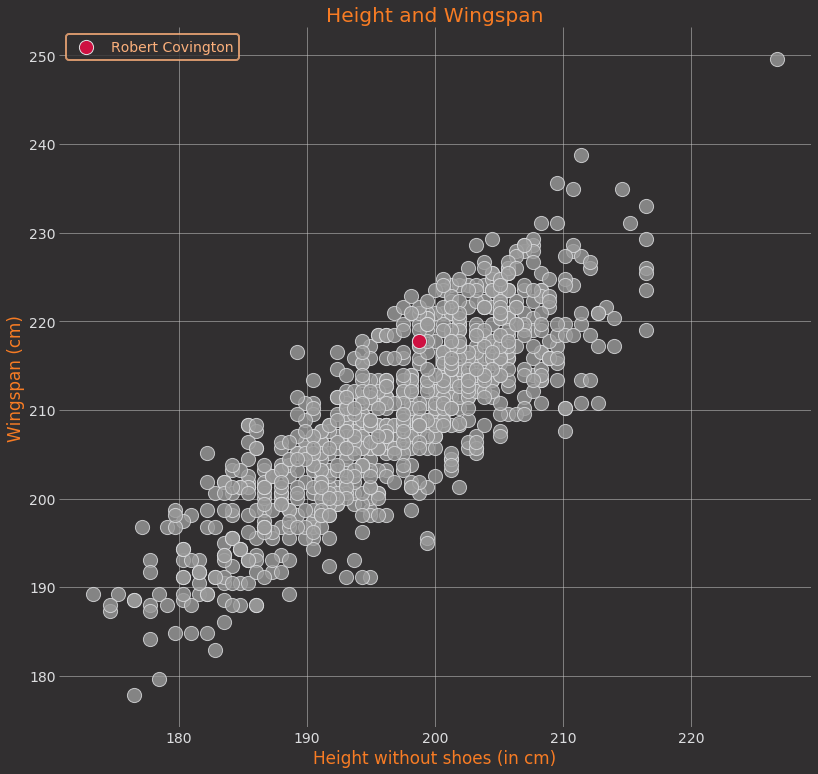

In [51]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=other.HEIGHT_M, y=other.WINGSPAN_M, s=200, edgecolors=bball_white, lw=1, color="#9A9A9A", alpha=0.8)
ax.scatter(x=cov_data.HEIGHT_M, y=cov_data.WINGSPAN_M, s=200, edgecolors=bball_white, lw=1, color=hou_colors, alpha=1.0, label='Robert Covington')
#ax.scatter(x=all_dfs.FG3M, y=all_dfs.MEAN_3PT_DISTANCE_M, s=200, edgecolors=bball_white, lw=1, color=colors, alpha=0.8)
ax.set_xlabel("Height without shoes (in cm)", color=bball_orange)
ax.set_ylabel("Wingspan (cm)", color=bball_orange)
ax.set_title("Height and Wingspan", color=bball_orange)

ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)
ax.grid(alpha=0.5)

ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_white)
    
legend = ax.legend()
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)

    
#adjust_text(texts, arrowprops=dict(arrowstyle='-', color=bball_light_orange), expand_points=(1.2, 1.3))

## Trade, Change of position

#### Blocks vs Height

In [13]:
league_bio = LeagueDashPlayerBioStats().get_data_frames()[0]
league_stats = LeagueDashPlayerStats(date_from_nullable=date_from).get_data_frames()[0]

In [14]:
merged = pd.merge(left=league_stats, right=league_bio, on='PLAYER_ID')

In [15]:
merged = merged.loc[merged.GP_x > 5]

In [16]:
sorted_blocks = merged.sort_values(by='BLK', ascending=False)

In [17]:
sorted_blocks = sorted_blocks.iloc[:100]

In [18]:
sorted_blocks.loc[:, 'HEIGHT_M'] = sorted_blocks.PLAYER_HEIGHT_INCHES * 2.54

In [19]:
other = sorted_blocks.loc[sorted_blocks.PLAYER_ID != covington_id]
roco_data = sorted_blocks.loc[sorted_blocks.PLAYER_ID == covington_id]

In [20]:
top_players = other.iloc[:5]

In [21]:
all_text = pd.concat([roco_data, top_players])

12

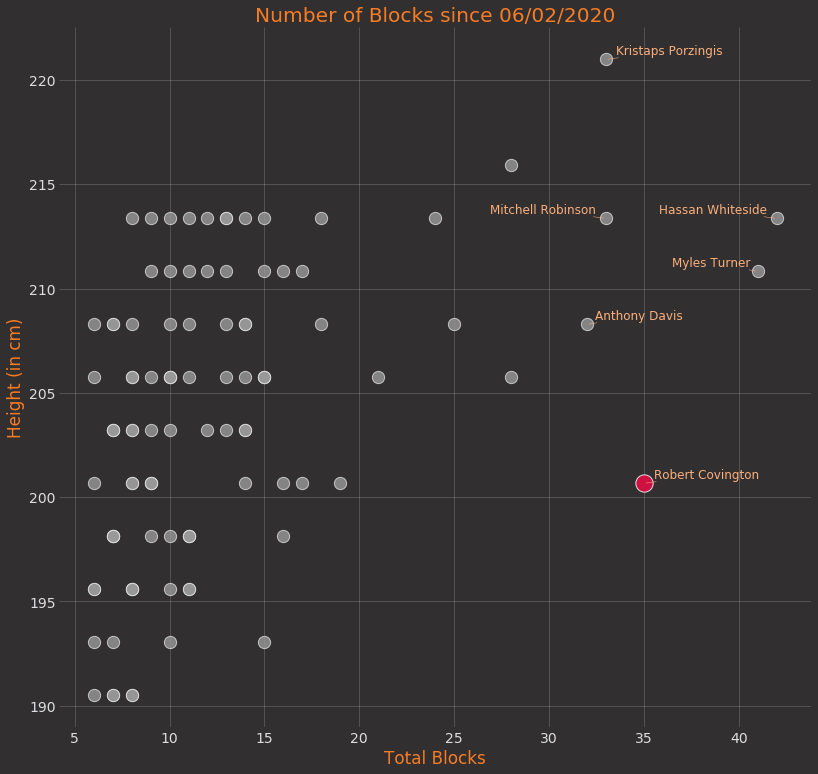

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=sorted_blocks.BLK, y=sorted_blocks.HEIGHT_M, s=150, edgecolors=bball_white, lw=1, color="#9A9A9A", alpha=0.8)
ax.scatter(x=roco_data.BLK, y=roco_data.HEIGHT_M, s=300, edgecolors=bball_white, lw=1, color=hou_colors, alpha=1.0)
#ax.scatter(x=all_dfs.FG3M, y=all_dfs.MEAN_3PT_DISTANCE_M, s=200, edgecolors=bball_white, lw=1, color=colors, alpha=0.8)
ax.set_xlabel("Total Blocks", color=bball_orange)
ax.set_ylabel("Height (in cm)", color=bball_orange)
ax.set_title("Number of Blocks since 06/02/2020", color=bball_orange)

ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)

ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_white)

ax.grid(alpha=0.2, color=bball_white)
texts = []
for index in range(len(all_text)):
    item = all_text.iloc[index]
    texts.append(ax.text(x=item.BLK, y=item.HEIGHT_M, s=item.PLAYER_NAME_x, size=12, color=bball_light_orange))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color=bball_light_orange), expand_points=(1.2, 1.3))

Change of blocks, steals, deflections and contests

##### Možda ovo napravit s Radar Chartom?, Ili samo bar chart za comparison? Ili 

#### Change of blocks, steals, deflections, contests, defended shots

Change of positions defended

In [46]:
roco_logs = PlayerGameLogs(date_from_nullable=date_from,season_nullable='2019-20', player_id_nullable=covington_id)

In [47]:
logs_df = roco_logs.get_data_frames()[0]

In [61]:
roco_dfs = []
for index in range(len(logs_df)):
    item = logs_df.iloc[index]
    matchup_data = BoxScoreMatchups(game_id=item.GAME_ID)
    matchup_df = matchup_data.get_data_frames()[0]
    roco_dfs.append(matchup_df.loc[matchup_df.DEF_PLAYER_ID == covington_id])
    sleep(0.25)

In [63]:
roco_total = pd.concat(roco_dfs, ignore_index=True)

In [79]:
url = f"https://stats.nba.com/stats/matchupsrollup?DateFrom=&DateTo=&DefPlayerID=&LeagueID=00&Matchup=Offense&Outcome=&PORound=0&PerMode=Totals&Season=2019-20&SeasonType=Regular+Season"
data = requests.get(url=url, headers=headers).json()

offense_matchups = pd.DataFrame(data=data['resultSets'][0]['rowSet'], columns=data['resultSets'][0]['headers'])

In [99]:
positions = []
matchup_times = []
for index in range(len(roco_total)):
    item = roco_total.iloc[index]
    position = offense_matchups.loc[offense_matchups.DEF_PLAYER_ID == item.OFF_PLAYER_ID].sort_values(by='PERCENT_OF_TIME', ascending=False).iloc[1].POSITION
    positions.append(position)
    matchup_time = item.MATCHUP_MIN
    minutes = int(matchup_time.split(":")[0])
    seconds = int(matchup_time.split(":")[1])
    total_time = minutes * 60 + seconds
    matchup_times.append(total_time)

In [100]:
roco_total.loc[:, 'OFF_POSITION'] = positions

In [101]:
roco_total.loc[:, 'MATHUP_TIME'] = matchup_times

In [113]:
url = f"https://stats.nba.com/stats/matchupsrollup?DateFrom=&DateTo=&DefPlayerID={covington_id}&LeagueID=00&Matchup=Defense&Outcome=&PORound=0&PerMode=Totals&Season=2019-20&SeasonType=Regular+Season"
data = requests.get(url=url, headers=headers).json()

roco_matchups = pd.DataFrame(data=data['resultSets'][0]['rowSet'], columns=data['resultSets'][0]['headers'])

In [115]:
roco_times = []
for index in range(len(roco_matchups)):
    item = roco_matchups.iloc[index]
    matchup_time = item.MATCHUP_MIN
    minutes = int(matchup_time.split(":")[0])
    seconds = int(matchup_time.split(":")[1])
    total_time = minutes * 60 + seconds
    roco_times.append(total_time)

In [118]:
roco_total.groupby(by='OFF_POSITION').sum()

,OFF_TEAM_ID,OFF_PLAYER_ID,DEF_TEAM_ID,DEF_PLAYER_ID,PARTIAL_POSS,PCT_DEFENDER_TOTAL_TIME,PCT_OFF_TOTAL_TIME,PCT_TOTAL_TIME_BOTH_ON,SWITCHES_ON,PLAYER_PTS,...,MATCHUP_FG3A,MATCHUP_FG3_PCT,HELP_BLK,HELP_FGM,HELP_FGA,HELP_FG_PERC,MATCHUP_FTM,MATCHUP_FTA,SFL,MATHUP_TIME
OFF_POSITION,,,,,,,,,,,,,,,,,,,,,
C,24159191267,11592950,24159191175,3052440,70.35,1.540,2.017,2.709,0,32,...,0,0.000,0,0,0,0.0,6,11,5,1110
F,64424510083,43358955,64424509800,8139840,194.43,4.375,6.050,10.185,0,70,...,18,3.833,0,0,0,0.0,11,18,12,3012
G,122406569176,78037623,122406568620,15465696,375.89,8.082,9.589,13.918,0,165,...,58,10.917,0,0,0,0.0,17,23,14,5756


In [116]:
roco_matchups.loc[:, 'MATCHUP_TIME'] = roco_times

### Defensive efficiency

#### Court

In [28]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False, zorder=None):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, zorder=zorder)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color, zorder=zorder)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=7)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=zorder)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=zorder)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None, zorder=zorder)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [29]:
from nba_api.stats.endpoints.playerdashptshotdefend import PlayerDashPtShotDefend

In [30]:
LESS_SIX = "LESS_THAN_SIX"
SIX_TEN = "SIX_TEN"
TEN_FIFTEEN = "TEN_FIFTEEN"
GREATER_FIFTEEN = "GREATER_FIFTEEN"
THREE_POINTER = "THREE_POINTER"

In [31]:
def_dist_keys = [LESS_SIX, SIX_TEN, TEN_FIFTEEN, GREATER_FIFTEEN, THREE_POINTER]

In [37]:
def get_defend_data(player_id, date_to="", date_from="", per_game: bool=False, season = "2019-20"):
    defend_data = PlayerDashPtShotDefend(player_id=player_id, team_id=0, date_from_nullable=date_from, date_to_nullable=date_to, per_mode_simple='PerGame' if per_game else 'Totals', season=season)
    
    defend_df = defend_data.get_data_frames()[0]
    
    less_than_10 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Less Than 10 Ft'].iloc[0]
    less_than_6 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Less Than 6 Ft'].iloc[0]
    greater_than_15 = defend_df.loc[defend_df.DEFENSE_CATEGORY == 'Greater Than 15 Ft'].iloc[0]
    two_point = defend_df.loc[defend_df.DEFENSE_CATEGORY == '2 Pointers'].iloc[0]
    three_point = defend_df.loc[defend_df.DEFENSE_CATEGORY == '3 Pointers'].iloc[0]

    greater_fifteen_two_fga = greater_than_15.D_FGA - three_point.D_FGA
    greater_fifteen_two_fgm = greater_than_15.D_FGM - three_point.D_FGM

    ten_fifteen_fga = two_point.D_FGA - greater_fifteen_two_fga - less_than_10.D_FGA
    ten_fifteen_fgm = two_point.D_FGM - greater_fifteen_two_fgm - less_than_10.D_FGM

    six_ten_fga = less_than_10.D_FGA - less_than_6.D_FGA
    six_ten_fgm = less_than_10.D_FGM - less_than_6.D_FGM
    
    made_dict = {
        LESS_SIX: less_than_6.D_FGM,
        SIX_TEN: six_ten_fgm,
        TEN_FIFTEEN: ten_fifteen_fgm,
        GREATER_FIFTEEN: greater_fifteen_two_fgm,
        THREE_POINTER: three_point.D_FGM
    }
    attempt_dict = {
        LESS_SIX: less_than_6.D_FGA,
        SIX_TEN: six_ten_fga,
        TEN_FIFTEEN: ten_fifteen_fga,
        GREATER_FIFTEEN: greater_fifteen_two_fga,
        THREE_POINTER: three_point.D_FGA
    }
    return made_dict, attempt_dict
    
    

In [38]:
team_categories = [
    'Overall',
    '3 Pointers',
    '2 Pointers',
    'Less Than 6Ft',
    'Less Than 10Ft',
    'Greater Than 15Ft'
]

def get_team_defense_df(defense_category, season='2019-20'):
    url = f"https://stats.nba.com/stats/leaguedashptteamdefend?Conference=&DateFrom=&DateTo=&DefenseCategory={defense_category}&Division=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&Period=0&Season={season}&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision="
    resp = requests.get(url=url, headers=headers)
    data_dict = resp.json()
    return pd.DataFrame(data=data_dict['resultSets'][0]['rowSet'], columns=data_dict['resultSets'][0]['headers'])

def get_league_averages(season = '2019-20'):
    avg_dict = {}

    category_dict = {}
    for category in team_categories:
        category_dict[category] = get_team_defense_df(defense_category=category, season=season)
        sleep(0.25)

    averaged_dicts = {}
    for category in category_dict:
        averaged_dicts[category] = category_dict[category].mean()

    greater_fifteen_two_fga_avg = averaged_dicts['Greater Than 15Ft'].FGA_GT_15 - averaged_dicts['3 Pointers'].FG3A
    greater_fifteen_two_fgm_avg = averaged_dicts['Greater Than 15Ft'].FGM_GT_15 - averaged_dicts['3 Pointers'].FG3M

    ten_fifteen_fga_avg = averaged_dicts['2 Pointers'].FG2A - greater_fifteen_two_fga_avg - averaged_dicts['Less Than 10Ft'].FGA_LT_10
    ten_fifteen_fgm_avg = averaged_dicts['2 Pointers'].FG2M - greater_fifteen_two_fgm_avg - averaged_dicts['Less Than 10Ft'].FGM_LT_10

    six_ten_fga_avg = averaged_dicts['Less Than 10Ft'].FGA_LT_10 - averaged_dicts['Less Than 6Ft'].FGA_LT_06
    six_ten_fgm_avg = averaged_dicts['Less Than 10Ft'].FGM_LT_10 - averaged_dicts['Less Than 6Ft'].FGM_LT_06
    
    avg_dict = {
        LESS_SIX: averaged_dicts['Less Than 6Ft'].FGM_LT_06 / averaged_dicts['Less Than 6Ft'].FGA_LT_06,
        SIX_TEN: six_ten_fgm_avg / six_ten_fga_avg,
        TEN_FIFTEEN: ten_fifteen_fgm_avg / ten_fifteen_fga_avg,
        GREATER_FIFTEEN: greater_fifteen_two_fgm_avg / greater_fifteen_two_fga_avg,
        THREE_POINTER: averaged_dicts['3 Pointers'].FG3M / averaged_dicts['3 Pointers'].FG3A
    }
    return avg_dict

#### Arc methods

In [68]:
from matplotlib.patches import Circle, PathPatch
from matplotlib.path import Path

def get_six_feet_arc(color):
    vertices = [
        [40, -47.5],
        [140, 96],
        [-139, 98],
        [-40, -47.5],
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_six_ten_feet_arc(color):
    vertices = [
        [-90, -47.5],
        [-162, 150],
        [162, 150],
        [90, -47.5],
        [38, -47.5],
        [140, 96],
        [-139, 98],
        [-38, -47.5],   
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 

            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_ten_fifteen_arc(color):
    vertices = [
        [-144, -47.5],
        [-200, 215],
        [200, 215],
        [144, -47.5],
        [90, -47.5],
        [162, 150],
        [-162, 150],
        [-90, -47.5],
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)
    
def get_greater_fifteen(color):
    vertices = [
        [-220, -47.5],
        [-220, 90.5],
        [-130, 285],
        [130, 285],
        [220, 90.5],
        [220, -47.5],
        [144, -47.5],
        [200, 215],
        [-200, 215],
        [-144, -47.5],
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.LINETO, Path.CURVE4, Path.CURVE4, Path.CURVE4, 

            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=2)

def get_three_point_area(color):
    vertices = [
        [-250, -47.5],
        [-220, -47.5],
        [-220, 90.5],
        [-142, 285],
        [142, 285],
        [220, 90.5],
        [220, -47.5],
        [250, -47.5],
        [250, 160],
        [190, 370],
        [-190, 370],
        [-250, 160]
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO,
             Path.CURVE4, Path.CURVE4, Path.CURVE4, 
             Path.LINETO, Path.LINETO, Path.LINETO,
             Path.CURVE4, Path.CURVE4, Path.CURVE4,
            ]
    arc_path = Path(vertices=vertices, codes=codes)
    return PathPatch(path=arc_path, color=color, alpha=0.6, zorder=3, lw=0)

In [69]:
def plot_texts(ax, made_dict, attempt_dict, six_pct, six_ten_pct, 
               ten_fifteen_pct, greater_fifteen_pct, three_pointer_pct, is_per_game=False):
    alpha = 0.6
    if not is_per_game:
        ax.text(x=0, y=20, s=f"{made_dict[LESS_SIX]} / {attempt_dict[LESS_SIX]}\n{six_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=70, s=f"{made_dict[SIX_TEN]} / {attempt_dict[SIX_TEN]}\n{six_ten_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=120,
                s=f"{made_dict[TEN_FIFTEEN]} / {attempt_dict[TEN_FIFTEEN]}\n{ten_fifteen_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=170,
                s=f"{made_dict[GREATER_FIFTEEN]} / {attempt_dict[GREATER_FIFTEEN]}\n{greater_fifteen_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=260, s=f"{made_dict[THREE_POINTER]} / {attempt_dict[THREE_POINTER]}\n{three_pointer_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
    else:
        ax.text(x=0, y=20, s=f"{made_dict[LESS_SIX]:.2f} / {attempt_dict[LESS_SIX]:.2f}\n{six_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=70, s=f"{made_dict[SIX_TEN]:.2f} / {attempt_dict[SIX_TEN]:.2f}\n{six_ten_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=120,
                s=f"{made_dict[TEN_FIFTEEN]:.2f} / {attempt_dict[TEN_FIFTEEN]:.2f}\n{ten_fifteen_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=170,
                s=f"{made_dict[GREATER_FIFTEEN]:.2f} / {attempt_dict[GREATER_FIFTEEN]:.2f}\n{greater_fifteen_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})
        ax.text(x=0, y=260, s=f"{made_dict[THREE_POINTER]:.2f} / {attempt_dict[THREE_POINTER]:.2f}\n{three_pointer_pct*100:.2f}%",
                color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': alpha, 'edgecolor': 'black', 'boxstyle' : 'round'})




def plot_for_player(player_id, team_id, title, date_from="", date_to="", is_per_game=False, season='2019-20'):
    fig, ax = plt.subplots(figsize=(12, 12))
    # colors_dict = {0:'red', 1:'green'}
    made_dict, attempt_dict = get_defend_data(player_id=player_id, date_from=date_from, date_to=date_to, per_game=is_per_game, season=season)
    league_average = get_league_averages(season=season)

    texts = []
    output_list = []

    cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], n_colors=21, as_cmap=False)
    bin_res = {item: index for index, item in enumerate(list(range(-10, 11, 1)))}
    
    six_pct = made_dict[LESS_SIX]/attempt_dict[LESS_SIX]
    six_ten_pct = made_dict[SIX_TEN]/attempt_dict[SIX_TEN]
    ten_fifteen_pct = made_dict[TEN_FIFTEEN]/attempt_dict[TEN_FIFTEEN]
    greater_fifteen_pct = made_dict[GREATER_FIFTEEN]/attempt_dict[GREATER_FIFTEEN]
    three_pointer_pct = made_dict[THREE_POINTER]/attempt_dict[THREE_POINTER]
    
    six_zone_diff = np.clip((six_pct - league_average[LESS_SIX])*100,-10, 10)
    six_ten_diff = np.clip((six_ten_pct - league_average[SIX_TEN])*100,-10, 10)
    ten_fifteen_diff = np.clip((ten_fifteen_pct - league_average[TEN_FIFTEEN])*100,-10, 10)
    greater_fifteen_two_diff = np.clip((greater_fifteen_pct - league_average[GREATER_FIFTEEN])*100,-10, 10)
    three_diff = np.clip((three_pointer_pct - league_average[THREE_POINTER])*100,-10, 10)
    
    plot_texts(ax=ax, made_dict=made_dict, attempt_dict=attempt_dict, six_pct=six_pct, 
               six_ten_pct=six_ten_pct, ten_fifteen_pct=ten_fifteen_pct, greater_fifteen_pct=greater_fifteen_pct,
               three_pointer_pct=three_pointer_pct, is_per_game=is_per_game)


    # GREATER THAN 15
    ax.add_patch(get_greater_fifteen(color=cmap[bin_res[int(greater_fifteen_two_diff)]]))
    # 10-15 ft
    ax.add_patch(get_ten_fifteen_arc(color=cmap[bin_res[int(ten_fifteen_diff)]]))
    # 6-10 ft
    ax.add_patch(get_six_ten_feet_arc(color=cmap[bin_res[int(six_ten_diff)]]))
    # <6 ft
    ax.add_patch(get_six_feet_arc(color=cmap[bin_res[int(six_zone_diff)]]))
    # 3 pt
    ax.add_patch(get_three_point_area(color=cmap[bin_res[int(three_diff)]]))

    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/{season.split('-')[0]}/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    ax.imshow(img, extent=(92, 252, -47, 70), zorder=7)


    ax.text(x=164, y=400, s="Comparison with\nleague average percentage", color=bball_white, fontsize=12, ha='center')
    ax.text(x=90, y=365, s="BETTER\nDefending", color=bball_white, fontsize=12)
    ax.scatter(x=130, y=385, s=550, marker='o', c="#4159E1", edgecolors=bball_white)
    ax.scatter(x=147, y=385, s=550, marker='o', c="#B0E0E6", edgecolors=bball_white)
    ax.scatter(x=164, y=385, s=550, marker='o', c="#FFFF99", edgecolors=bball_white)
    ax.scatter(x=181, y=385, s=550, marker='o', c="#EF3330", edgecolors=bball_white)
    ax.scatter(x=198, y=385, s=550, marker='o', c="#AB2020", edgecolors=bball_white)
    ax.text(x=201, y=365, s="   WORSE\nDefending", color=bball_white, fontsize=12)


    # Title
    ax.set_title(title, size=20, color=bball_light_orange)
    #adjust_text(texts=texts, expand_points=(1.2, 1.9))
    
    ax.text(x=-170, y=405, s=f"Numbers (Per Game) in Boxes:", color=bball_white, fontsize=12, ha='center')
    ax.text(x=-170, y=380, s=f"Allowed FGM / Allowed FGA\nAllowed FG%", fontsize=12,
            color='black', ha='center', zorder=6, bbox={'facecolor': '#CDDADA', 'alpha': 0.6, 'edgecolor': 'black', 'boxstyle' : 'round'})

    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange, zorder=7)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    for circle in output_list:    
        ax.add_artist(circle)

In [70]:
minny_id = find_teams_by_full_name("Minnesota Timberwolves")[0]['id']
hou_id = find_teams_by_full_name("Houston Rockets")[0]['id']

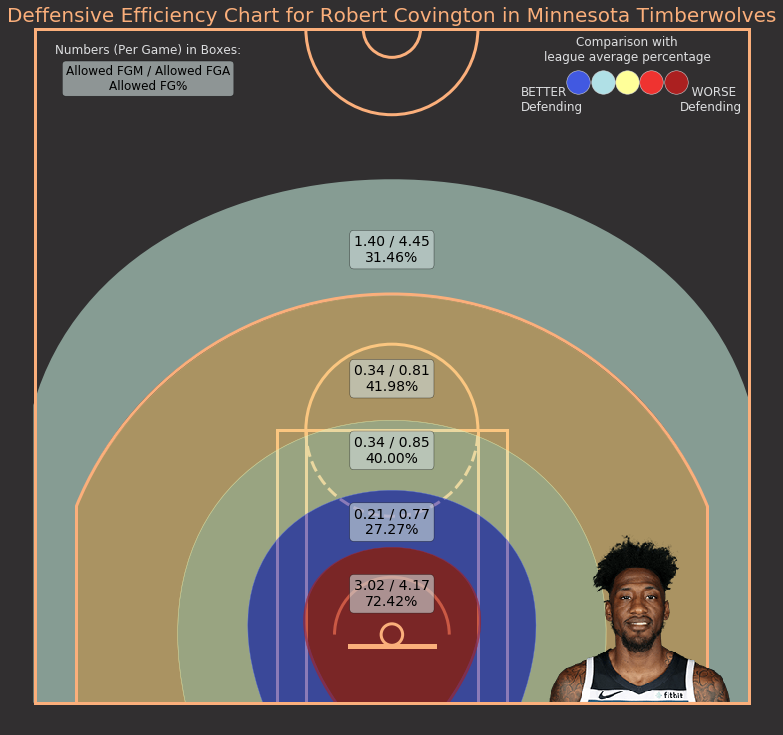

In [71]:
plot_for_player(player_id=covington_id, team_id=minny_id, date_to=date_to, title="Deffensive Efficiency Chart for Robert Covington in Minnesota Timberwolves", is_per_game=True)

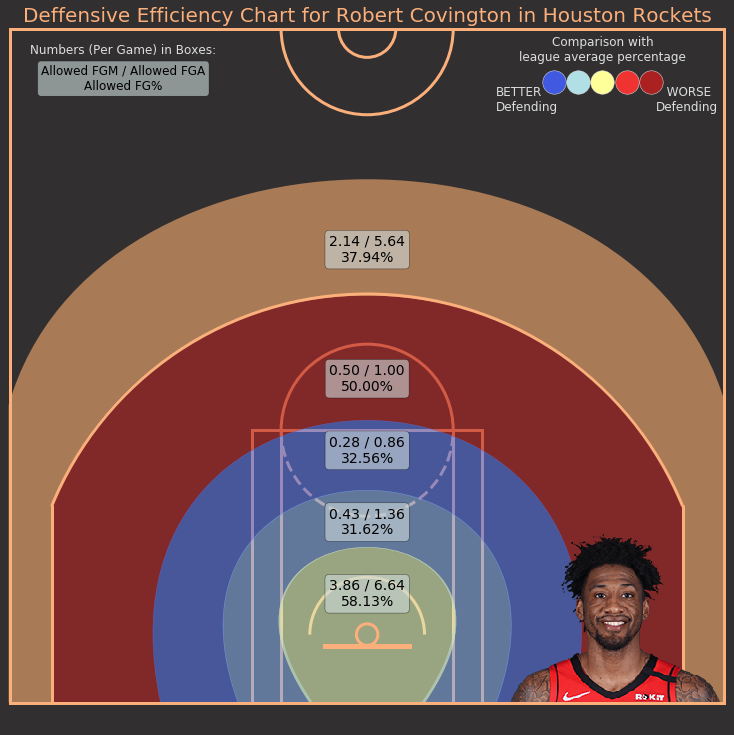

In [72]:
plot_for_player(player_id=covington_id, team_id=hou_id, date_from=date_from, title="Deffensive Efficiency Chart for Robert Covington in Houston Rockets", is_per_game=True)

In [73]:
philly_id = find_teams_by_full_name("Philadelphia 76ers")[0]['id']

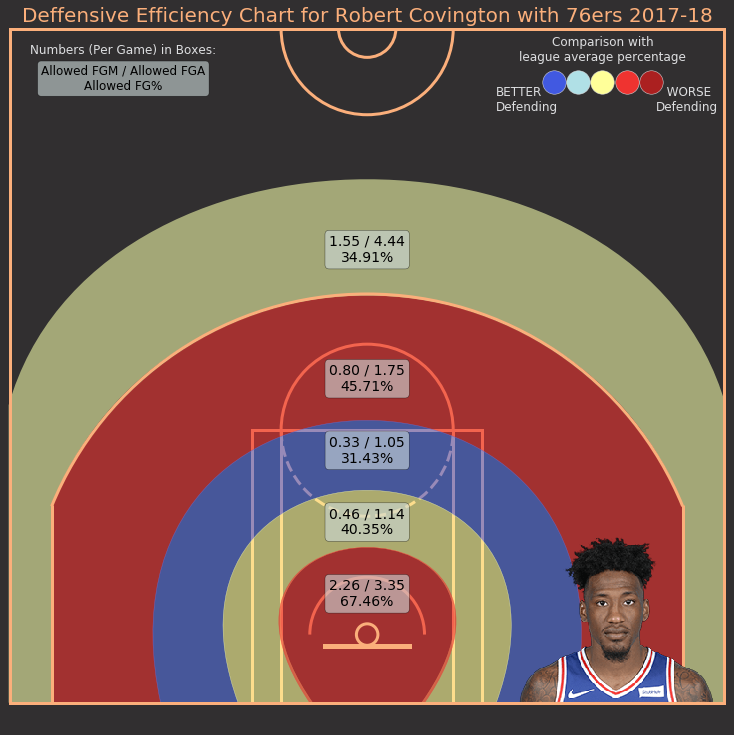

In [74]:
plot_for_player(player_id=covington_id, team_id=philly_id, title="Deffensive Efficiency Chart for Robert Covington with 76ers 2017-18", is_per_game=True, season='2017-18')

Chart of height/blocks

##### Možda ovo napravit s Radar Chartom?, Ili samo bar chart za comparison? Ili 

#### Change of blocks, steals, deflections, contests, defended shots

In [15]:
def get_hustle_data(date_from="", date_to="", season='2019-20'):
    resp = requests.get(url=hustle_url(date_to=date_to, date_from=date_from, season=season), headers=headers)
    hustle_dict = resp.json()
    return pd.DataFrame(data=hustle_dict['resultSets'][0]['rowSet'], columns=hustle_dict['resultSets'][0]['headers'])

In [16]:
before_hustle = get_hustle_data(date_to=date_to)

In [17]:
after_hustle = get_hustle_data(date_from=date_from)

In [18]:
all_hustle = get_hustle_data()

In [19]:
non_covington = all_hustle.loc[all_hustle.PLAYER_ID != covington_id]

In [20]:
before_roco = before_hustle.loc[before_hustle.PLAYER_ID == covington_id]
after_roco = after_hustle.loc[after_hustle.PLAYER_ID == covington_id]

In [21]:
non_covington = non_covington.loc[non_covington.G > 10]

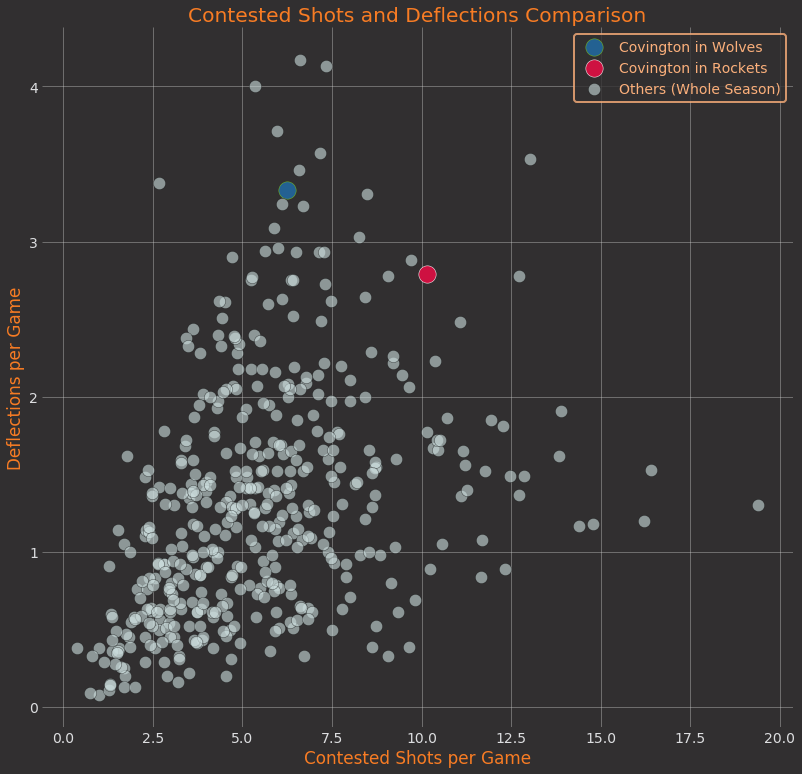

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=before_roco.CONTESTED_SHOTS, y=before_roco.DEFLECTIONS, s=300, edgecolors='#78BE20', color='#236192', label='Covington in Wolves')
ax.scatter(x=after_roco.CONTESTED_SHOTS, y=after_roco.DEFLECTIONS, s=300, edgecolors='white', color='#CE1141', label='Covington in Rockets')
ax.scatter(x=non_covington.CONTESTED_SHOTS, y=non_covington.DEFLECTIONS, s=150, edgecolors='black', color='#CCDDDD', alpha=0.6, label='Others (Whole Season)')

ax.set_xlabel("Contested Shots per Game", color=bball_orange)
ax.set_ylabel("Deflections per Game", color=bball_orange)
ax.set_title("Contested Shots and Deflections Comparison", color=bball_orange)


ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ax.grid(b=True, alpha=0.4)

legend = ax.legend()
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)

In [23]:
seasons = [
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
]

In [24]:
season_dfs = []
for season in seasons:
    hustle_df = get_hustle_data(season=season)
    hustle_df.loc[:, 'SEASON'] = season
    season_dfs.append(hustle_df)
    sleep(0.25)

In [25]:
concated = pd.concat(season_dfs)

In [26]:
roco_data = concated.loc[concated.PLAYER_ID == covington_id]

In [27]:
roco_data = roco_data.iloc[1:]

In [28]:
deflections = roco_data.DEFLECTIONS.tolist()

In [29]:
contested_2pt = roco_data.CONTESTED_SHOTS_2PT.tolist()

In [30]:
contested_3pt = roco_data.CONTESTED_SHOTS_3PT.tolist()

In [31]:
deflections += [before_roco.DEFLECTIONS.iloc[0], after_roco.DEFLECTIONS.iloc[0]]

In [32]:
contested_2pt += [before_roco.CONTESTED_SHOTS_2PT.iloc[0], after_roco.CONTESTED_SHOTS_2PT.iloc[0]]

In [33]:
contested_3pt += [before_roco.CONTESTED_SHOTS_3PT.iloc[0], after_roco.CONTESTED_SHOTS_3PT.iloc[0]]

In [34]:
labels = roco_data.SEASON.tolist() + ['2019-20 MIN', '2019-20 HOU']

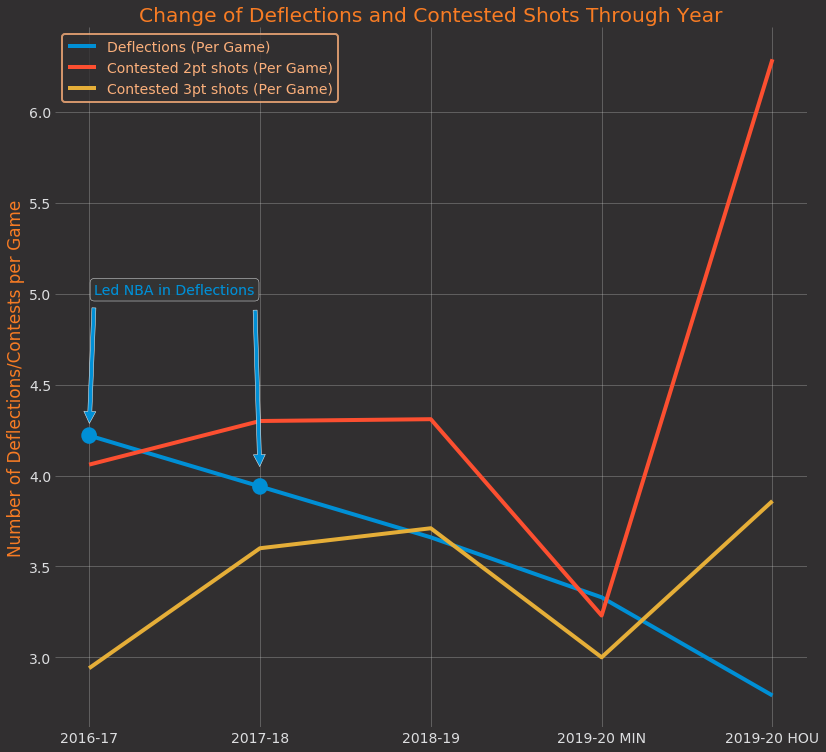

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(labels, deflections, label='Deflections (Per Game)')
ax.plot(labels, contested_2pt, label='Contested 2pt shots (Per Game)')
ax.plot(labels, contested_3pt, label='Contested 3pt shots (Per Game)')

ax.set_ylabel("Number of Deflections/Contests per Game", color=bball_orange)
ax.set_title("Change of Deflections and Contested Shots Through Year", color=bball_orange)

ax.annotate('Led NBA in Deflections', xy=(0, 4.25), xytext=(0.5, 5.0), color='#008fd5', ha='center',
            arrowprops=dict(facecolor='#008fd5', shrink=0.05), bbox={'facecolor': '#343434', 'alpha': 0.7, 'edgecolor': bball_white, 'boxstyle' : 'round'})
ax.annotate('Led NBA in Deflections', xy=(1, 4.0), xytext=(0.5, 5.0), color='#008fd5', ha='center',
            arrowprops=dict(facecolor='#008fd5', shrink=0.05), bbox={'facecolor': '#343434', 'alpha': 0.7, 'edgecolor': bball_white, 'boxstyle' : 'round'})

output_list = []
output_list.append(plt.Circle((0, deflections[0]), 0.04, color='#008fd5', fill=True, alpha=1.0, lw=2))
output_list.append(plt.Circle((1, deflections[1]), 0.04, color='#008fd5', fill=True, alpha=1.0, lw=2))
for patch in output_list:
    ax.add_patch(patch)

ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ax.grid(b=True, alpha=0.3)

legend = ax.legend()
frame = legend.get_frame()
frame.set_facecolor(bball_gray)
frame.set_linewidth(2)
frame.set_edgecolor(bball_light_orange)
for text in legend.get_texts():
    text.set_color(bball_light_orange)



## Team Impact

In [27]:
team_stats = TeamPlayerOnOffSummary(team_id=hou_id, date_from_nullable=date_from)

In [30]:
on_court = team_stats.get_data_frames()[1]

In [32]:
off_court = team_stats.get_data_frames()[2]

In [34]:
merged_df = pd.merge(left=on_court, right=off_court, on='VS_PLAYER_ID', suffixes=('_ON', '_OFF'))

In [37]:
merged_df = merged_df.sort_values(by='MIN_ON', ascending=False).iloc[:9]

In [43]:
merged_df = merged_df.sort_values(by='MIN_ON')

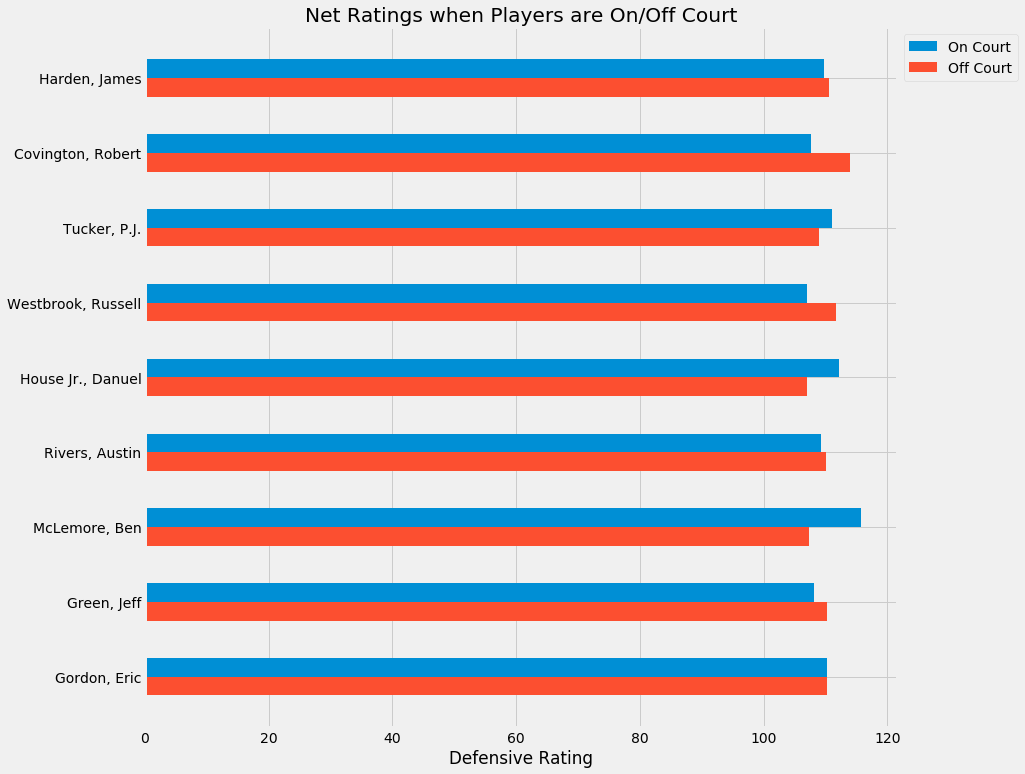

In [56]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.barh(y=[index+0.125 for index, _ in enumerate(merged_df.VS_PLAYER_NAME_ON)], width=merged_df.DEF_RATING_ON, label='On Court', height=0.25)
ax.barh(y=[index-0.125 for index, _ in enumerate(merged_df.VS_PLAYER_NAME_ON)], width=merged_df.DEF_RATING_OFF, label='Off Court', height=0.25)
#ax.barh(y=top_players.VS_PLAYER_NAME_ON, width=top_players.DIFF, edgecolor='black', ls='dotted', fc=(0, 1, 1, 0.0), lw=1.5, label='On - Off')
ax.set_title("Net Ratings when Players are On/Off Court")
ax.set_xlabel("Defensive Rating")
ax.set_yticks([index for index, _ in enumerate(merged_df.VS_PLAYER_NAME_ON.tolist())])
ax.set_yticklabels(merged_df.VS_PLAYER_NAME_ON.tolist())

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [59]:
merged_df.loc[:, 'DEF_DIFF'] = merged_df.DEF_RATING_ON - merged_df.DEF_RATING_OFF

In [64]:
sorted_def = merged_df.sort_values(by='DEF_DIFF', ascending=False)

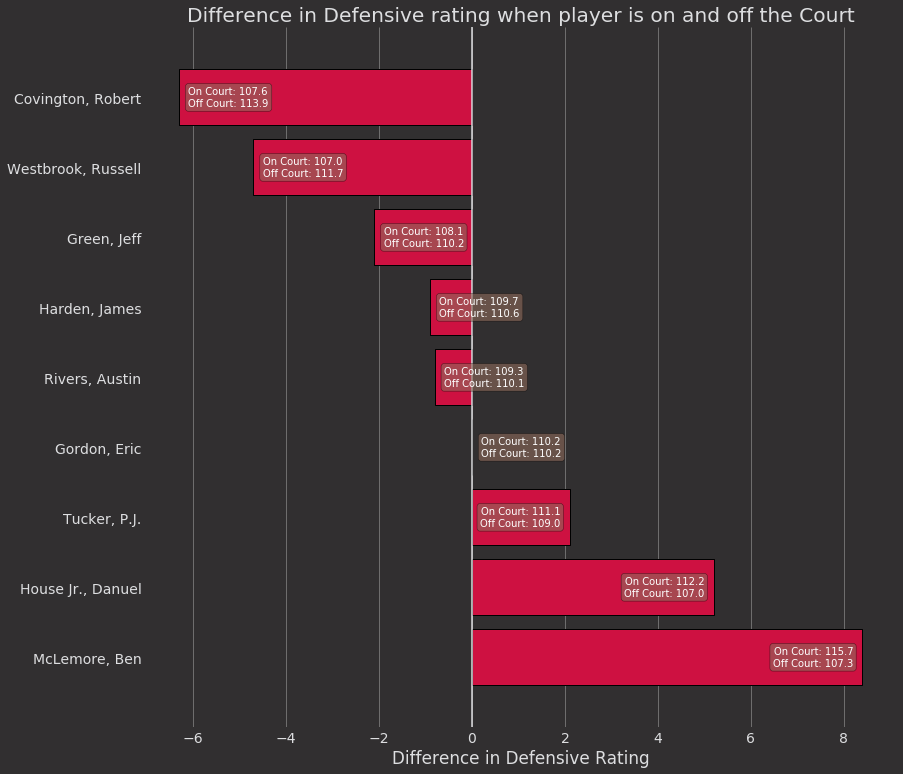

In [101]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.barh(y=sorted_def.VS_PLAYER_NAME_ON, width=sorted_def.DEF_DIFF, label='On Court', color=hou_colors, edgecolor='black', lw=1, joinstyle='round')
#ax.barh(y=[index-0.125 for index, _ in enumerate(merged_df.VS_PLAYER_NAME_ON)], width=merged_df.DEF_RATING_OFF, label='Off Court', height=0.25)
#ax.barh(y=top_players.VS_PLAYER_NAME_ON, width=top_players.DIFF, edgecolor='black', ls='dotted', fc=(0, 1, 1, 0.0), lw=1.5, label='On - Off')
ax.set_title("Difference in Defensive rating when player is on and off the Court", color=bball_white)
ax.set_xlabel("Difference in Defensive Rating", color=bball_white)
ax.vlines(x=0, ymin=-1, ymax=len(sorted_def), lw=1.5, color=bball_white)
ax.set_ylim(-1, len(sorted_def))

for index in range(len(sorted_def)):
    item = sorted_def.iloc[index]
    if item.DEF_DIFF > 0:
        ha='right'
        x_dim = item.DEF_DIFF - 0.2
    else:
        x_dim = item.DEF_DIFF+0.2
        ha='left'
    ax.text(x=x_dim, y=index, s=f'On Court: {item.DEF_RATING_ON}\nOff Court: {item.DEF_RATING_OFF}',
            va='center', size=10, color='white', bbox={'facecolor': '#8D6A5B', 'alpha': 0.6, 'edgecolor': 'black', 'boxstyle' : 'round'},
           ha=ha)
    
ax.set_facecolor(bball_gray)
fig.set_facecolor(bball_gray)
ax.set_frame_on(False)
ticks = ax.get_xticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ticks = ax.get_yticklabels()
for tick in ticks:
    tick.set_color(bball_white)
ax.grid(b=True, alpha=0.4, axis='x')
ax.grid(b=False, axis='y')

#ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

Defensive rating On Off, for whole team

def rating for whole league

## Offense

Shot selection and shot chart before/after

In [164]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [171]:
from collections import Counter
import operator
def create_bins(data_frame, bin_number_x = 30, bin_number_y=300 / (500.0 / 30.0), league_average = None,
                width = 500, height = 300, norm_x = 250, norm_y = 48):
    """
    Method which creates bins the dataset into squared grid. This is used so that plot looks nicer than the raw
    locations plot. Along with binning the data, the percentages per zones and for each bin are calculated here
    and added to the copy of data_frame object so they can be used for plotting later.

    :return: Returns the copied  data_frame pandas DataFrame object with additional info about the shots.
    """
    # Binned x and y coordinates
    x_bins, y_bins = [], []
    # Copying the dataset to add more data
    copied_df = data_frame.copy()
    # Keys are basically x_bin and y_bin
    keys = []
    # Counter of shots and shots made per locations
    location_counts, location_made = Counter(), Counter()
    # be found

    # Size of elements in bin, they should be the same
    bin_size_x = float(width) / float(bin_number_x)
    bin_size_y = float(height) / float(bin_number_y)
    # List for locations of shots
    locations_annotated = []
    # Counter of shots and shots made per zone
    zones_counts, zones_made = Counter(), Counter()

    # Maximum size of an element in one bin
    max_size = int((int(bin_size_x) - 1) * (int(bin_size_y) - 1))

    # Keys that are in restricted area will be stored here, this will be used for finding maximum number of shots
    restricted_area_keys = []

    # Dictionary which will determine the color of marker in bin
    percentage_color_dict = {}

    for i in range(len(data_frame)):

        # Row from data frame
        row = data_frame.iloc[i]

        x_shot_orig, y_shot_orig = row.LOC_X, row.LOC_Y

        # Normalize
        x_shot = x_shot_orig + norm_x  # to put minimum to zero
        y_shot = y_shot_orig + norm_y  # to put minimum to zero

        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)

        # Key for dicts
        key = (curr_x_bin, curr_y_bin)

        if row.SHOT_ZONE_BASIC == "Restricted Area":
            restricted_area_keys.append(key)

        # Counting number of shots made and shots shot
        keys.append(key)
        location_counts[key] += 1
        location_made[key] += row.SHOT_MADE_FLAG

        basic_shot_zone, shot_zone_area = row.SHOT_ZONE_BASIC, row.SHOT_ZONE_AREA
        zone_dist = row.SHOT_ZONE_RANGE

        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)

        # Creating key for zones
        zone_key = (basic_shot_zone, shot_zone_area, zone_dist)

        # Counting the occurences based on both bin_key and zone_key, because of that we have dict in dict
        if key in percentage_color_dict:
            if zone_key in percentage_color_dict[key]:
                percentage_color_dict[key][zone_key] = percentage_color_dict[key][zone_key] + 1
            else:
                percentage_color_dict[key][zone_key] = 1
        else:
            percentage_color_dict[key] = {}
            percentage_color_dict[key][zone_key] = 1

        zones_counts[zone_key] += 1

        if row.SHOT_MADE_FLAG:
            zones_made[zone_key] += 1

    shot_locations_percentage = []  # percentage in given bin
    shot_locations_counts = []
    raw_counts = []
    # List which contains comparison for each shot with league average in that zone
    shot_comparison = []
    # List which contains comparison of player's shooting in zone vs league average
    per_zone_comparison = []
    per_zone_percentage = []

    # Finding the maximal number of shots from data
    non_ra = []
    for key in location_counts:
        if key not in restricted_area_keys:
            if location_counts[key] not in non_ra:
                non_ra.append(location_counts[key])

    sorted_non_ra = sorted(non_ra)
    max_out_of_restricted = float(sorted_non_ra[-1])

    for j in range(len(data_frame)):
        key = keys[j]
        x_bin, y_bin = key[0], key[1]
        shot_percent = float(location_made[key]) / location_counts[key]
        # shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            # Getting info about zone
            # We are getting that info from
            per_zone_counter_from_percentage_color_dict = percentage_color_dict[key]
            zone_key = max(per_zone_counter_from_percentage_color_dict.items(),
                           key=operator.itemgetter(1))[0]

            shot_zone_basic = zone_key[0]
            shot_zone_area = zone_key[1]
            distance = zone_key[2]

            # Calculating the percentage in current zone
            zone_percent = 0.0 if zone_key not in zones_made else float(zones_made[zone_key]) / \
                                                                  float(zones_counts[zone_key])

            # Retrieving league average percentage for current zone
            avg_percentage = league_average.loc[
                (league_average.SHOT_ZONE_BASIC == shot_zone_basic) &
                (league_average.SHOT_ZONE_AREA == shot_zone_area) &
                (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT.iloc[
                0
            ]
            # Comparison of league average and each shot
            shot_comparison.append(np.clip((shot_percent - avg_percentage) * 100, -10, 10))
            # Comparison of zone and league average
            per_zone_comparison.append(np.clip((zone_percent - avg_percentage) * 100, -10, 10))
            # Percentage of shot in current zone, kinda inaccurate info, good for some other type of plot
            per_zone_percentage.append(zone_percent * 100)

        # Calculating value to which the markers will be scaled later on
        # The data in restricted is scaled to maximum out of restricted area, because players usually have a lot
        # more shots in restricted area
        value_to_scale = max_out_of_restricted if location_counts[key] > max_out_of_restricted else \
            location_counts[key]
        # Storing the data into a list
        shot_locations_counts.append((float(value_to_scale) / max_out_of_restricted) * max_size)

        # Count of shots per bin
        raw_counts.append(location_counts[key])

        # Middle of current and next bin is where we will place the marker in real coordinates
        unbinned_x = ((x_bin * float(width)) / bin_number_x + (
                (x_bin + 1) * float(width)) / bin_number_x) / 2 - norm_x
        unbinned_y = ((y_bin * float(height)) / bin_number_y + (
                (y_bin + 1) * float(height)) / bin_number_y) / 2 - norm_y

        # Adding binned locations
        x_bins.append(unbinned_x)
        y_bins.append(unbinned_y)

    # Binned locations
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    # Percentage comparison with league averages
    if league_average is not None:
        # Comparison of each shot with league average for that zone
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = shot_comparison
        # Comparison of each zone with league average for that zone
        copied_df['PCT_LEAGUE_COMPARISON_ZONE'] = per_zone_comparison
    # Percentage of shots for that location
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage
    # Percentage of whole zone (not in comparison with league average)
    copied_df['LOC_ZONE_PERCENTAGE'] = per_zone_percentage
    # Scaled count of shots and count of shots per bin
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['LOC_RAW_COUNTS'] = raw_counts

    return copied_df

In [168]:
import matplotlib.path as mpath
from matplotlib.colors import colorConverter
def get_smooth_square():
    """
    Creates marker which represents smooth square.

    :return: new matplotlib.path.Path instance
    """
    marker = np.array([[-0.8, 1.0],
                       [-1.0, 0.8],
                       [-1.0, -0.8],
                       [-0.8, -1.0],
                       [0.8, -1.0],
                       [1.0, -0.8],
                       [1.0, 0.8],
                       [0.8, 1.0],
                       [-0.8, 1.0]])

    return mpath.Path(marker, closed=True)

def plot_shotchart(original_df, data_frame, title, mode='light', plot_text=False, drop_single_shots=False):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    # colors_dict = {0:'red', 1:'green'}
    cmap_list = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"],n_colors=21, as_cmap=False)

    
    # LOC_PERCENTAGE -> total perc
    # PCT_LEAGUE_AVG_COMPARISON -> comparison per bins
    # PCT_LEAGUE_COMPARISON_ZONE -> comparison per zones only
    # LOC_X, LOC_Y -> real locs
    # BIN_LOC_X, BIN_LOC_Y -> binned locations
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    marker = get_smooth_square()
    edge_color = colorConverter.to_rgba('black', alpha=.5)
    dropped_dups = data_frame.drop_duplicates(subset=['BIN_LOC_X', 'BIN_LOC_Y'], keep='first')
    if drop_single_shots:
        dropped_dups = dropped_dups.loc[dropped_dups.LOC_RAW_COUNTS > 1]
    
    colors = [cmap_list[int(item)+10] for item in dropped_dups.PCT_LEAGUE_COMPARISON_ZONE.tolist()]
    paths = ax.scatter(
        x=dropped_dups.BIN_LOC_X,
        y=dropped_dups.BIN_LOC_Y,
        marker=marker,
        s=dropped_dups.LOC_COUNTS * 2,
        c=colors,
        #cmap=colors,
        edgecolors=bball_white,
    )

    if mode == 'dark':
        background_color="#000000"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
    # Frequency
    

    ax.text(x=-240, y=360, s="Less\nFrequent", color=bball_white, fontsize=12)
    ax.scatter(x=-218, y=377, s=20 * 1 * 2.5, marker=marker, c=bball_white)
    ax.scatter(x=-205, y=377, s=20 * 3 * 2.5, marker=marker, c=bball_white)
    ax.scatter(x=-190, y=377, s=20 * 6 * 2.5, marker=marker, c=bball_white)
    ax.scatter(x=-171, y=377, s=20 * 9 * 2.5, marker=marker, c=bball_white)
    ax.scatter(x=-151, y=377, s=20 * 11 * 2.5, marker=marker, c=bball_white)
    ax.text(x=-153, y=360, s="      More\nFrequent", color=bball_white, fontsize=12)


    # Efficiency

    ax.text(x=164, y=400, s="Comparison with\nleague average percentage", color=bball_white, fontsize=12, ha='center')
    ax.text(x=95, y=360, s="Below\nAverage", color=bball_white, fontsize=12)
    ax.scatter(x=130, y=377, s=550, marker=marker, c="#4159E1", edgecolors=bball_white)
    ax.scatter(x=147, y=377, s=550, marker=marker, c="#B0E0E6", edgecolors=bball_white)
    ax.scatter(x=164, y=377, s=550, marker=marker, c="#FFFF99", edgecolors=bball_white)
    ax.scatter(x=181, y=377, s=550, marker=marker, c="#EF3330", edgecolors=bball_white)
    ax.scatter(x=198, y=377, s=550, marker=marker, c="#AB2020", edgecolors=bball_white)
    ax.text(x=201, y=360, s="   Above\nAverage", color=bball_white, fontsize=12)
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    for index in range(len(df_by_zone_median)):
        loc_x = df_by_zone_median.iloc[index].LOC_X
        loc_y = df_by_zone_median.iloc[index].LOC_Y
        zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
        zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
        zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
        if df_by_zone_median.iloc[index].name not in text_location_mapping:
            continue
        x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
        key = df_by_zone_median.iloc[index].name
        binned_data = dropped_dups.loc[
            (dropped_dups.SHOT_ZONE_BASIC == key[0]) & 
            (dropped_dups.SHOT_ZONE_AREA == key[1]) & 
            (dropped_dups.SHOT_ZONE_RANGE == key[2])]
        if len(binned_data) < 3:
            continue
        if zone_shots_attempted < 5:
            continue
        print(df_by_zone_median.iloc[index].name, zone_shots_attempted, len(binned_data))
        ax.text(x=x, y=y, s=f"{zone_percentage:.2f}%", ha='center', c='black',
               bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})
    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    ax.set_frame_on(False)
    
    team_id = original_df.iloc[0].TEAM_ID
    player_id = original_df.iloc[0].PLAYER_ID
    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    ax.imshow(img, extent=(132, 252, -48, 40))
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)

    # Title
    plt.title(title, size=24, color=bball_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-252,252)
    ax.set_ylim(-65,423)

    return dropped_dups, df_by_zone_sum

In [169]:
player_id = find_players_by_full_name("Robert Covington")[0]['id']

player_data = ShotChartDetail(season_nullable='2019-20', team_id=0, player_id=player_id, context_measure_simple='FGA', date_to_nullable=date_to)

player_df = player_data.get_data_frames()[0]

league_avg = player_data.get_data_frames()[1]
player_df.LOC_X = -player_df.LOC_X

('Above the Break 3', 'Center(C)', '24+ ft.') 96.0 30
('Above the Break 3', 'Left Side Center(LC)', '24+ ft.') 85.0 36
('Above the Break 3', 'Right Side Center(RC)', '24+ ft.') 96.0 34
('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.') 6.0 4
('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.') 28.0 16
('Left Corner 3', 'Left Side(L)', '24+ ft.') 20.0 8
('Mid-Range', 'Left Side Center(LC)', '16-24 ft.') 5.0 5
('Mid-Range', 'Right Side(R)', '8-16 ft.') 6.0 6
('Restricted Area', 'Center(C)', 'Less Than 8 ft.') 127.0 12
('Right Corner 3', 'Right Side(R)', '24+ ft.') 12.0 8


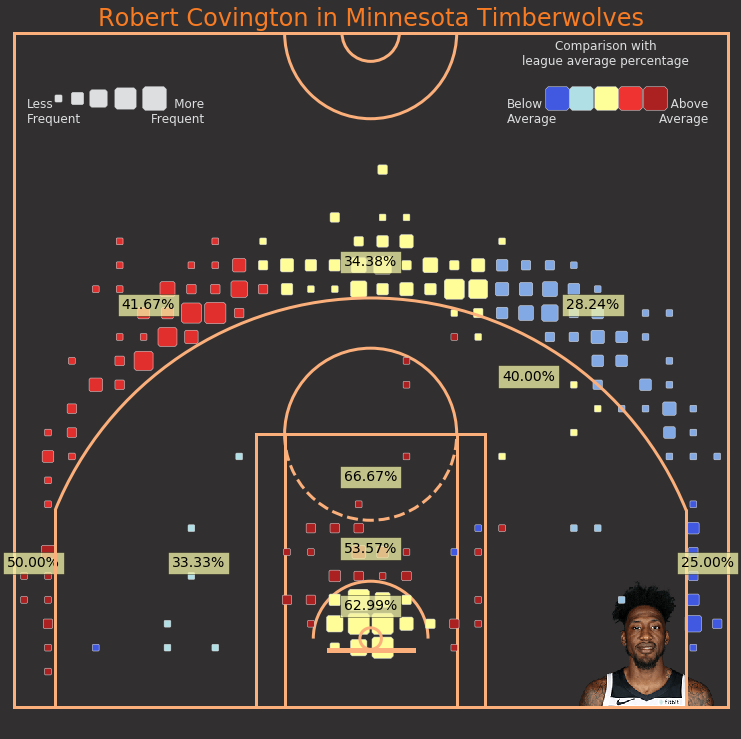

In [174]:
binned_df = create_bins(data_frame=player_df, league_average=league_avg)

_ = plot_shotchart(original_df=player_df, data_frame=binned_df, title="Robert Covington in Minnesota Timberwolves", mode='light', plot_text=False)

In [176]:
player_id = find_players_by_full_name("Robert Covington")[0]['id']

player_data = ShotChartDetail(season_nullable='2019-20', team_id=0, player_id=player_id, context_measure_simple='FGA', date_from_nullable=date_from)

player_df = player_data.get_data_frames()[0]

league_avg = player_data.get_data_frames()[1]
player_df.LOC_X = -player_df.LOC_X

('Above the Break 3', 'Center(C)', '24+ ft.') 19.0 13
('Above the Break 3', 'Left Side Center(LC)', '24+ ft.') 32.0 18
('Above the Break 3', 'Right Side Center(RC)', '24+ ft.') 36.0 21
('Left Corner 3', 'Left Side(L)', '24+ ft.') 6.0 4
('Restricted Area', 'Center(C)', 'Less Than 8 ft.') 35.0 11
('Right Corner 3', 'Right Side(R)', '24+ ft.') 18.0 11


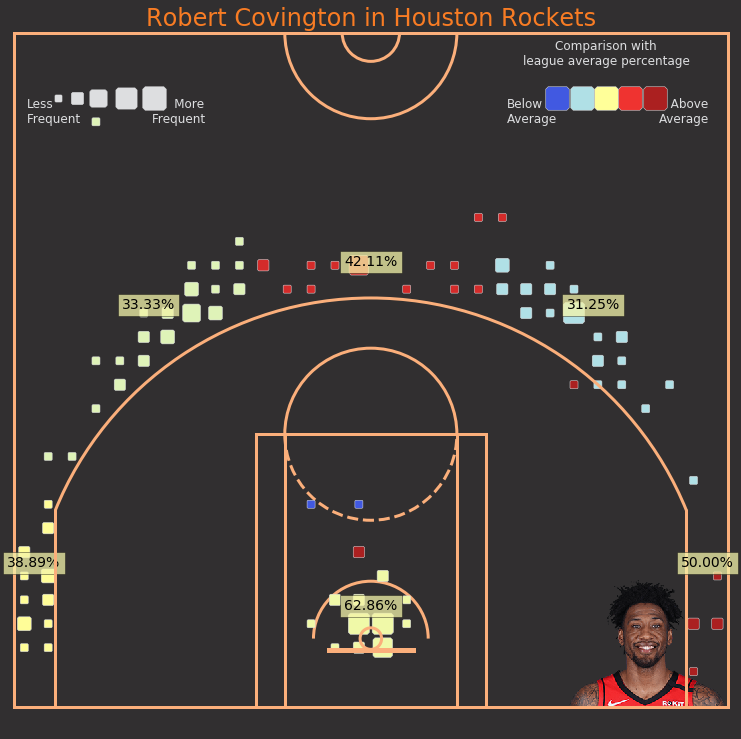

In [177]:

binned_df = create_bins(data_frame=player_df, league_average=league_avg)

_ = plot_shotchart(original_df=player_df, data_frame=binned_df, title="Robert Covington in Houston Rockets", mode='light', plot_text=False)